In [46]:
!pip install contractions
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import seaborn as sns
import unicodedata
import contractions
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import learning_curve
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

**DATA ACQUISITION**

In [47]:
import  opendatasets as od

In [48]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


In [49]:
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
non_depressed_1=pd.read_csv('C:/Users/archi/projects/sentiment analysis/ml/code/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=col_names)

In [50]:
final_data=pd.read_csv('C:/Users/archi/projects/sentiment analysis/ml/code/OurMLdataset.csv')

In [51]:
final_data

,id,tweet,label
0,1.228030e+18,cmon do not you want to see what kind of tatto...,0
1,5.158770e+17,what we need to do in life to be at peace when...,0
2,8.377520e+17,finish my research poster to present at a conf...,0
3,9.628340e+17,i be the problem,1
4,4.533340e+17,get to see my idol the other day wish she be s...,1
...,...,...,...
7647,2.923020e+17,if you want to achieve anything in this world ...,0
7648,1.386030e+18,i have be wait to get verify before i send thi...,0
7649,9.460330e+17,i only lie so i do not have to see tear of dis...,1
7650,1.123660e+18,i tell my therapist i just want to be as happy...,0


**PREPROCESSING**

In [52]:
print("Dimensions of our Dataset: ", final_data.shape)
print("\n")

print("Datset Info: \n")
final_data.info()

Dimensions of our Dataset:  (7652, 3)


Datset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      7652 non-null   float64
 1   tweet   7652 non-null   object 
 2   label   7652 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 179.5+ KB


In [53]:
print("\033[1m" + "Null Values" + "\033[0m\n")
print(final_data.isnull().sum(), "\n")
print("\033[1m" + "______________________________________________________________________________" + "\033[0m\n")
print("\033[1m" + "Duplicate Values" + "\033[0m\n")
display(final_data[final_data.duplicated(keep=False)])
final_data.drop_duplicates(inplace = True)
final_data.reset_index(inplace=True)
final_data.drop(['index'],axis=1,inplace=True)
print("\n\033[1m" + "New DataSet Shape" + "\033[0m\n")
final_data.shape

Null Values

id       0
tweet    0
label    0
dtype: int64 

______________________________________________________________________________

Duplicate Values



,id,tweet,label
351,1.357910e+18,excerpt from milk feed,1
2828,2.618990e+17,just leave a tap with amaze company a culture ...,0
2885,1.357910e+18,excerpt from milk feed,1
5941,2.618990e+17,just leave a tap with amaze company a culture ...,0



New DataSet Shape



(7650, 3)

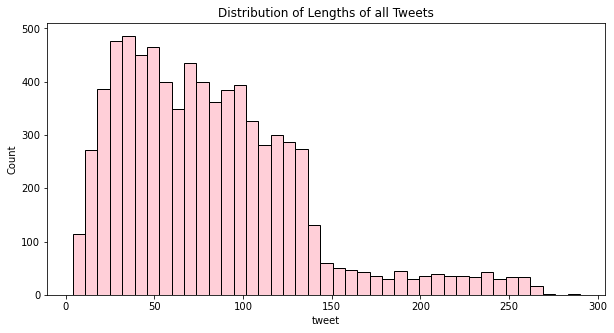

In [54]:
tweet_length = final_data["tweet"].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(tweet_length, color='pink')
plt.title("Distribution of Lengths of all Tweets")
plt.show()

Number of tweets for each depressive and non depressive category: 
 Non-Depressive    4592
Depressive        3058
Name: label, dtype: int64




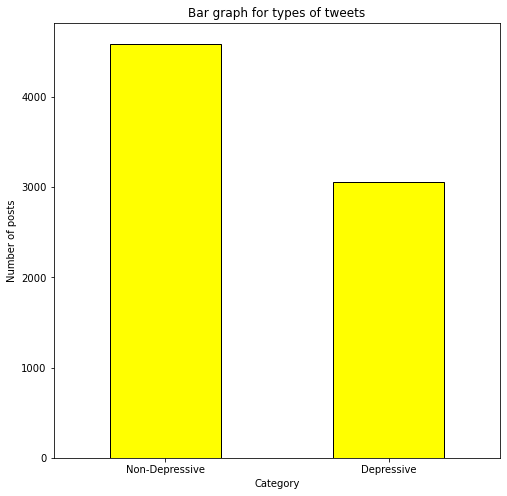

In [55]:
Counts=final_data.label.value_counts()
Counts.rename(index={0: 'Non-Depressive', 1: 'Depressive'}, inplace=True)
print("Number of tweets for each depressive and non depressive category: \n", Counts)
print("\n")
Counts.plot(kind='bar', figsize=(8,8), ylabel='Number of posts', xlabel='Category', title='Bar graph for types of tweets', color='yellow', edgecolor = 'black')
plt.xticks(rotation=360)
plt.show()

In [56]:
final_data.drop(['id'], axis=1, inplace = True)
data_before_preprocessing = final_data.copy(deep=True)

In [57]:
# Removing URL links from texts.
for i in range(final_data.shape[0]):
  processed_tweet_1 = re.sub(r"http\S+",' ', final_data._get_value(i, 'tweet'))
  final_data._set_value(i, 'tweet', processed_tweet_1)

# Removing non-ascii-characters.
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = [w for w in t.split(' ')]
  new_words = []
  for word in t:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
  t = " ".join(new_words)
  final_data._set_value(i, 'tweet', t)

# Expanding Contractions
for i in range(final_data.shape[0]):
  tweet = final_data._get_value(i, 'tweet')
  expanded_tweet = contractions.fix(tweet)
  final_data._set_value(i, 'tweet', expanded_tweet)

# Converting to lower case
final_data["tweet"] = final_data["tweet"].str.lower()

# Removing @ mentions from the tweets.
for i in range(final_data.shape[0]):
  tweet = final_data._get_value(i, 'tweet')
  clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
  final_data._set_value(i, 'tweet', clean_tweet)

#removing special characters and numbers from texts.
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  p = re.compile('\W+')
  t = re.sub(p, ' ', t)
  p = re.compile(r'[0-9]')
  t = re.sub(p, ' ', t)
  p = re.compile(r'[_+]')
  t = re.sub(p, ' ', t)
  final_data._set_value(i, 'tweet',t)

# Removing extra space
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  p = re.compile('\s+')
  t = re.sub(p, ' ', t)
  final_data._set_value(i, 'tweet', t)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# remove stop words
remove_words = stopwords.words("english")
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = " ".join([w for w in t.split(' ') if w not in remove_words])
  final_data._set_value(i, 'tweet', t)

#Lemmatization (grouping similar words)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
for i in range(final_data.shape[0]):
  t = final_data._get_value(i, 'tweet')
  t = " ".join([lemmatizer.lemmatize(w) for w in t.split(' ')])
  final_data._set_value(i, 'tweet', t)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\archi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\archi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
print("Text before preprocessing :", data_before_preprocessing.iloc[90,0], "\n")
print("Text after preprocessing :", final_data.iloc[90,0], "\n")

Text before preprocessing : love be not something we do to or for other people it be a bless a gift we give to ourselves 

Text after preprocessing : love something people bless gift give 



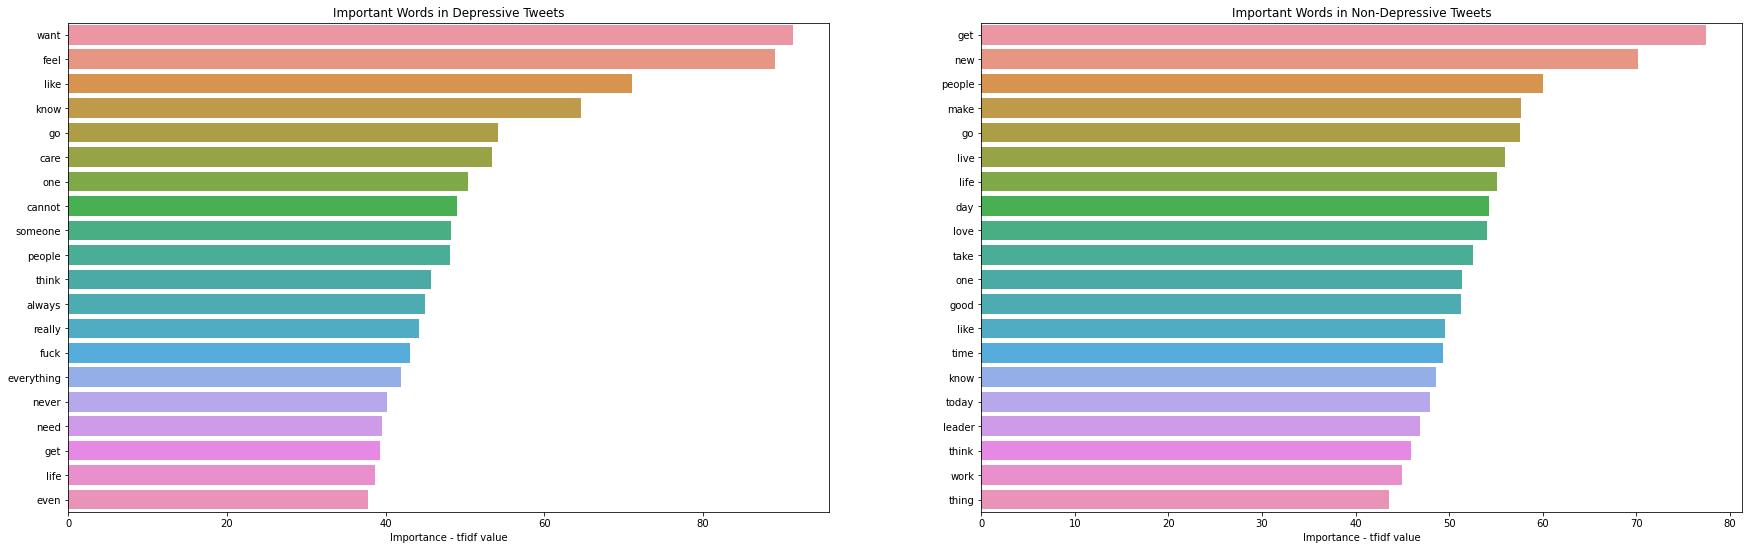

In [59]:
def imp_words(relevant_data, data):
    vec = TfidfVectorizer().fit(data)
    bag_of_words = vec.transform(relevant_data)
    words_sum = bag_of_words.sum(axis=0) 
    words_freq = [(word, words_sum[0, idx]) for word, idx in vec.vocabulary_.items()]
    imp_words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    imp_words_freq = imp_words_freq[:20]
    return imp_words_freq

depressive_data = final_data[final_data['label'] == 1]
imp_depressive_words = imp_words(depressive_data['tweet'], final_data['tweet'])

plt.figure(figsize=(30,9))
plt.subplot(1, 2, 1)
words = [x[0] for x in imp_depressive_words]
imp = [x[1] for x in imp_depressive_words]
sns.barplot(x = imp, y = words)
plt.xlabel('Importance - tfidf value')
plt.title('Important Words in Depressive Tweets')

non_depressive_data = final_data[final_data['label'] == 0]
imp_non_depressive_words = imp_words(non_depressive_data['tweet'], final_data['tweet'])

plt.subplot(1, 2, 2)
words = [x[0] for x in imp_non_depressive_words]
imp = [x[1] for x in imp_non_depressive_words]
sns.barplot(x = imp, y = words)
plt.xlabel('Importance - tfidf value')
plt.title('Important Words in Non-Depressive Tweets')
plt.savefig('bar.png')
plt.show()

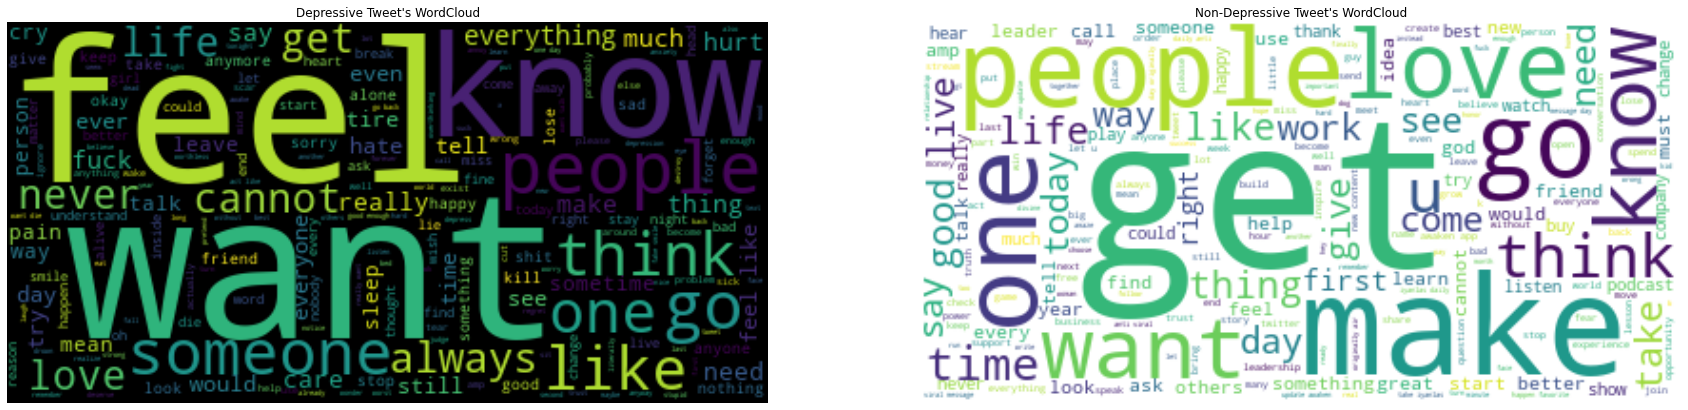

In [60]:
depressive_data= final_data[final_data['label']==1]
tweets = " ".join(depressive_data['tweet'].tolist())
wordcount=WordCloud(background_color="black", max_words=200, contour_width=3, stopwords=remove_words)
wordcount.generate(tweets)
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Depressive Tweet's WordCloud")
plt.imshow(wordcount, interpolation='bilinear')

print()

non_depressive_data= final_data[final_data['label']==0]
tweets = " ".join(non_depressive_data['tweet'].tolist())
wordcount=WordCloud(background_color="white", max_words=200, contour_width=3, stopwords=remove_words)
wordcount.generate(tweets)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Non-Depressive Tweet's WordCloud")
plt.imshow(wordcount, interpolation='bilinear')
plt.savefig('word_cloud.png')
plt.show()

**Feature Extraction**

In [61]:
frequency = final_data.tweet.str.split(expand = True).stack().value_counts()
relevant_words = frequency[frequency.values >= 10]
relevant_words

get            605
want           553
people         550
like           540
go             508
              ... 
officially      10
involve         10
acknowledge     10
define          10
shake           10
Length: 1038, dtype: int64

In [62]:
tweet_list = final_data.tweet.to_list()
vec = CountVectorizer(stop_words='english', max_features= len(relevant_words))
features = vec.fit_transform(tweet_list)
transformer = TfidfTransformer()
final_features =  transformer.fit_transform(features).toarray()
X = pd.DataFrame(final_features)
y = final_data['label']

**Train - Test Split**

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6885, 1038), (765, 1038), (6885,), (765,))

**LEARNING TECHNIQUES**

**Baseline model -** LOGISTIC REGRESSION

In [64]:
# Logistic regression
a = LogisticRegression(penalty="none", max_iter = 1000, C = 1, solver="lbfgs")
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
score = cross_val_score(a, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [0.82438316 0.83599419 0.81132075 0.82293179 0.81422351 0.81104651
 0.82412791 0.82848837 0.83139535 0.81395349]
Average Cross Validation score :0.8217865038647181


In [65]:
C = np.logspace(-3,3,7)
penalty = ["l1","l2"]
solver = ["liblinear"]
max_iter = [100, 500, 1000, 1500]

'''param_grid = dict(C=C, penalty = penalty, solver = solver, max_iter = max_iter)'''

param_grid = dict(C=C, penalty = penalty, solver = solver, max_iter = max_iter)
classifier = LogisticRegression(C=C, penalty = penalty, solver = solver, max_iter = max_iter)
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv = 5)
results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(results.cv_results_['mean_test_score'].max(), results.best_params_))
df_log_reg = pd.DataFrame(results.cv_results_)
df_log_reg



Best: 0.8379084967320262, using {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058139,0.005012,0.011394,0.001070,0.001,100,l1,liblinear,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
1,0.057879,0.000778,0.011864,0.001112,0.001,100,l2,liblinear,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
2,0.056684,0.001461,0.011420,0.001076,0.001,500,l1,liblinear,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l1',...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
3,0.057993,0.001817,0.010934,0.000829,0.001,500,l2,liblinear,"{'C': 0.001, 'max_iter': 500, 'penalty': 'l2',...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
4,0.055860,0.001023,0.011856,0.001814,0.001,1000,l1,liblinear,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
5,0.056960,0.001880,0.012261,0.002287,0.001,1000,l2,liblinear,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
6,0.058254,0.001901,0.011450,0.000759,0.001,1500,l1,liblinear,"{'C': 0.001, 'max_iter': 1500, 'penalty': 'l1'...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
7,0.055338,0.001370,0.011489,0.000576,0.001,1500,l2,liblinear,"{'C': 0.001, 'max_iter': 1500, 'penalty': 'l2'...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
8,0.054528,0.001193,0.010965,0.001176,0.01,100,l1,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.599855,0.599855,0.600581,0.600581,0.600581,0.600290,0.000356,45
9,0.055636,0.001099,0.012145,0.001280,0.01,100,l2,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.599855,0.600581,0.601307,0.601307,0.600581,0.600726,0.000543,41


In [66]:
sia = SentimentIntensityAnalyzer()

# Function to detect sentiment
def detect_sentiment(sentence):
    # Analyze the sentiment of the sentence using SentimentIntensityAnalyzer
    sentiment_scores = sia.polarity_scores(sentence)
    
    # Determine the overall sentiment label based on the compound score
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    # Return the sentiment label and the sentiment scores
    return sentiment_label, sentiment_scores

Cross Validation Scores are [0.8287373  0.85341074 0.83164006 0.83018868 0.84179971 0.8372093
 0.85319767 0.8619186  0.83430233 0.84156977]
Average Cross Validation score :0.8413974162081885

Performance on Test Set

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       459
           1       0.82      0.80      0.81       306

    accuracy                           0.85       765
   macro avg       0.85      0.84      0.84       765
weighted avg       0.85      0.85      0.85       765





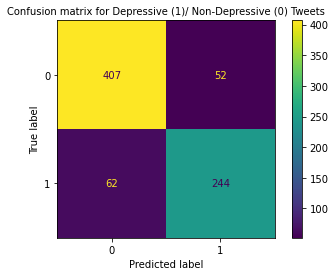

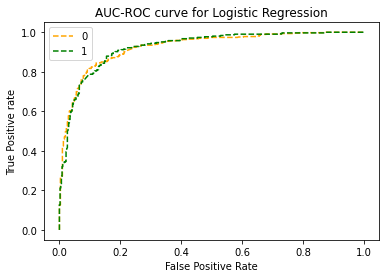

In [67]:
model = LogisticRegression(C = 10.0, max_iter = 100, penalty = 'l2', solver = 'liblinear')
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
score = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
plot_confusion_matrix(model, X_test, y_test)  
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('lg_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
fpr = {}
tpr = {}
thresh = {}
labels = model.classes_
pred_y_prob = model.predict_proba(X_test)
for i in range(2):    
  fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_y_prob[:,i],pos_label=labels[i])
      
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= labels[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= labels[1])

plt.title("AUC-ROC curve for Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

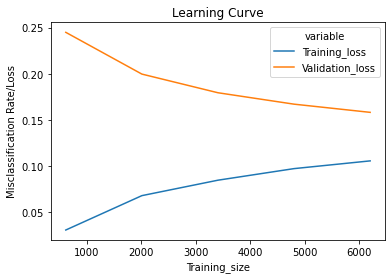

In [68]:
# Learning Curve
train_score = model.score(X_train, y_train)
train_size, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, cv=kf, scoring="accuracy", random_state=42)
test_scores = 1-np.mean(test_scores,axis=1)
train_scores = 1-np.mean(train_scores,axis=1)
lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
sns.lineplot(x="Training_size", y="value", data=lc, hue="variable")
plt.title("Learning Curve")
plt.ylabel("Misclassification Rate/Loss")
plt.savefig('learning_curve.png')
plt.show()

In [69]:
pickle.dump(model, open("model_Logistic_reg.pkl", 'wb'))

In [70]:
data_before_preprocessing.rename(columns={'tweet': 'tweet before preprocessing'}, inplace = True)
error = pd.DataFrame({'Actual_Values': y_test, 'Predicted_Values': predictions})
frames = [data_before_preprocessing.loc[X_test.index, 'tweet before preprocessing'], final_data.loc[X_test.index, 'tweet'], error]
error = pd.concat(frames, axis = 1)
error_analyse = error[error["Actual_Values"]!=error["Predicted_Values"]]
error_analyse

,tweet before preprocessing,tweet,Actual_Values,Predicted_Values
2337,shut the world off,shut world,1,0
3038,i maintain my innocence,maintain innocence,0,1
4239,have the hard conversations but with myself,hard conversation,1,0
5160,if there be people who care then there be hope...,people care hope hope lose one care,0,1
1430,you look happy well look closer,look happy well look closer,1,0
...,...,...,...,...
1168,it be the first time in a long time that puppe...,first time long time pupper sleep past noon st...,0,1
6591,oh nooooo nobody bet me to post a picture of m...,oh nooooo nobody bet post picture as boyfriend...,0,1
2168,i cannot wait to tell you about my suffer,cannot wait tell suffer,1,0
1758,one of those days where i just want to avoid e...,one day want avoid everyone anything,1,0


In [71]:
correct = error[error["Actual_Values"]==error["Predicted_Values"]]
correct

,tweet before preprocessing,tweet,Actual_Values,Predicted_Values
5752,i be not perfect i make mistake i hurt people ...,perfect make mistake hurt people say sorry act...,1,1
2465,this might be my best video ever and none of y...,might best video ever none watch view one bles...,0,0
5686,judge a leader by their level of service not t...,judge leader level service level privilege u a...,0,0
4747,dear mom i be sorry i could not make you any p...,dear mom sorry could make prouder sorry turn w...,1,1
5787,hear abbi jacobson find out she pay a nonrefun...,hear abbi jacobson find pay nonrefundable fee ...,0,0
...,...,...,...,...
179,if i be go down i be take one with me thank fo...,go take one thank watch fee hang series see gu...,0,0
5634,i be pretty sure my iphone be spy on me becaus...,pretty sure iphone spy start get lot ad water ...,0,0
5035,i think he be just as do with my study as i be...,think study zzz,0,0
4500,accord to my new friend food should be waste f...,accord new friend food waste comedic purpose d...,0,0


**Advanced model -** RNN

In [72]:
!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Dropout
import tensorflow as tf

In [73]:
X_test = final_data.loc[X_test.index, 'tweet'].to_frame()
y_test = final_data.loc[y_test.index, 'label']
X_mix = final_data.loc[X_train.index, 'tweet'].to_frame()
y_mix = final_data.loc[y_train.index, 'label']
X_train, X_val, y_train, y_val = train_test_split(X_mix, y_mix, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((6196, 1), (765, 1), (689, 1), (6196,), (765,), (689,))

In [74]:
training_data = X_train
training_data["label"] = y_train

testing_data = X_test
testing_data["label"] = y_test

val_data = X_val
val_data["label"] = y_val

training_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(training_data['tweet'].values, tf.string),tf.cast(training_data['label'].values, tf.int32))))
testing_data = (tf.data.Dataset.from_tensor_slices((tf.cast(testing_data['tweet'].values, tf.string),tf.cast(testing_data['label'].values, tf.int32))))
val_data = (tf.data.Dataset.from_tensor_slices((tf.cast(val_data['tweet'].values, tf.string),tf.cast(val_data['label'].values, tf.int32))))

training_dataset = training_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
testing_data = testing_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda tweet, label: tweet))

In [75]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
  model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_hppp')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=50, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt_hppp\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [76]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 176 and the optimal learning rate for the optimizer
is 0.001.



In [77]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=50, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
194/194 [==============================] - 4s 10ms/step - loss: 0.4543 - accuracy: 0.7711 - val_loss: 0.3523 - val_accuracy: 0.8578
Epoch 2/50
194/194 [==============================] - 2s 8ms/step - loss: 0.2957 - accuracy: 0.8783 - val_loss: 0.3577 - val_accuracy: 0.8547
Epoch 3/50
194/194 [==============================] - 2s 8ms/step - loss: 0.2494 - accuracy: 0.9035 - val_loss: 0.3556 - val_accuracy: 0.8641
Epoch 4/50
194/194 [==============================] - 2s 8ms/step - loss: 0.2001 - accuracy: 0.9198 - val_loss: 0.4066 - val_accuracy: 0.8484
Epoch 5/50
194/194 [==============================] - 2s 8ms/step - loss: 0.1501 - accuracy: 0.9404 - val_loss: 0.5098 - val_accuracy: 0.8578
Epoch 6/50
194/194 [==============================] - 2s 8ms/step - loss: 0.1184 - accuracy: 0.9561 - val_loss: 0.5969 - val_accuracy: 0.8469
Epoch 7/50
194/194 [==============================] - 2s 8ms/step - loss: 0.1015 - accuracy: 0.9593 - val_loss: 0.6060 - val_accuracy: 0.8547
Epoch

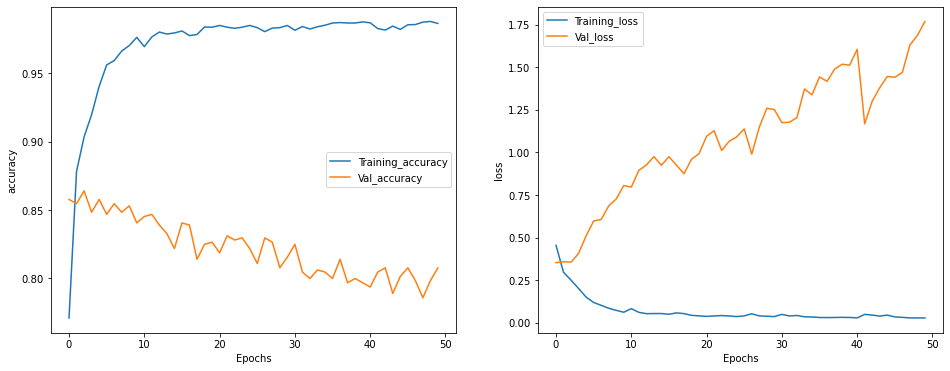

In [78]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('rnn_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [79]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/3
194/194 [==============================] - 4s 10ms/step - loss: 0.4676 - accuracy: 0.7702 - val_loss: 0.3481 - val_accuracy: 0.8641
Epoch 2/3
194/194 [==============================] - 2s 9ms/step - loss: 0.3010 - accuracy: 0.8783 - val_loss: 0.3665 - val_accuracy: 0.8562
Epoch 3/3
194/194 [==============================] - 2s 8ms/step - loss: 0.2574 - accuracy: 0.8993 - val_loss: 0.3808 - val_accuracy: 0.8594


In [80]:
pickle.dump(hypermodel, open("model_RNN.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://07527885-f8df-4de9-b640-62f97ff9c0c7/assets


In [81]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

194/194 [==============================] - 1s 3ms/step - loss: 0.1871 - accuracy: 0.9275
[train loss, train accuracy]: [0.18712066113948822, 0.9275338649749756]


In [82]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

24/24 [==============================] - 0s 3ms/step - loss: 0.3262 - accuracy: 0.8837
[test loss, test accuracy]: [0.32616931200027466, 0.8836601376533508]


24/24 [==============================] - 0s 3ms/step

Performance on Test Set

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       459
           1       0.84      0.87      0.86       306

    accuracy                           0.88       765
   macro avg       0.88      0.88      0.88       765
weighted avg       0.88      0.88      0.88       765





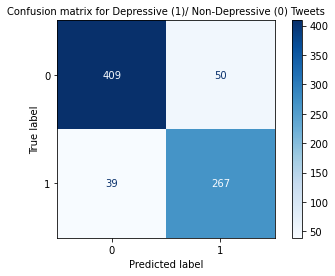



24/24 [==============================] - 0s 3ms/step


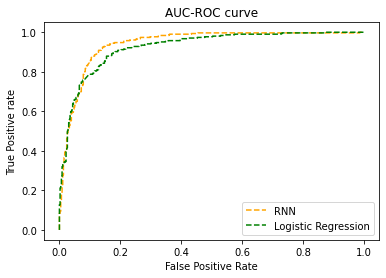

In [83]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('rnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_rnn, tpr_rnn, thresh_rnn = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_rnn, tpr_rnn, linestyle='--',color='orange', label="RNN")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()

**Advanced model -** LSTM

In [84]:
def build_model2(hp):
    hp_units = hp.Int('units',min_value=32,max_value=512,step=32)
    hp_drop_rate = hp.Float('rate', min_value=0, max_value=0.9, step=0.1)
    hp_choice = hp.Choice('activation',values=['relu', 'sigmoid'])

    model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.SpatialDropout1D(rate = hp_drop_rate),
     tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(rate = hp_drop_rate),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(rate = hp_drop_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model2,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir2',
                     project_name='intro_to_kt2')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=100, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from my_dir2\intro_to_kt2\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [85]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.001.



In [86]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=50, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
194/194 [==============================] - 9s 23ms/step - loss: 0.4757 - accuracy: 0.7521 - val_loss: 0.3466 - val_accuracy: 0.8469
Epoch 2/50
194/194 [==============================] - 3s 14ms/step - loss: 0.2965 - accuracy: 0.8740 - val_loss: 0.3407 - val_accuracy: 0.8641
Epoch 3/50
194/194 [==============================] - 2s 11ms/step - loss: 0.2633 - accuracy: 0.8917 - val_loss: 0.3592 - val_accuracy: 0.8687
Epoch 4/50
194/194 [==============================] - 2s 11ms/step - loss: 0.2475 - accuracy: 0.8969 - val_loss: 0.3627 - val_accuracy: 0.8687
Epoch 5/50
194/194 [==============================] - 2s 11ms/step - loss: 0.2332 - accuracy: 0.9043 - val_loss: 0.3703 - val_accuracy: 0.8672
Epoch 6/50
194/194 [==============================] - 3s 14ms/step - loss: 0.2241 - accuracy: 0.9062 - val_loss: 0.3840 - val_accuracy: 0.8656
Epoch 7/50
194/194 [==============================] - 3s 15ms/step - loss: 0.2196 - accuracy: 0.9095 - val_loss: 0.3973 - val_accuracy: 0.8641

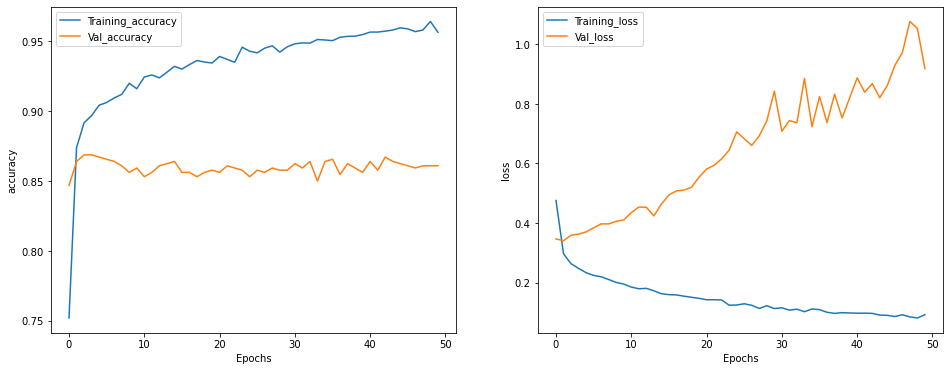

In [87]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('lstm_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [88]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/3
194/194 [==============================] - 10s 23ms/step - loss: 0.4674 - accuracy: 0.7613 - val_loss: 0.3430 - val_accuracy: 0.8516
Epoch 2/3
194/194 [==============================] - 2s 13ms/step - loss: 0.2962 - accuracy: 0.8751 - val_loss: 0.3371 - val_accuracy: 0.8641
Epoch 3/3
194/194 [==============================] - 3s 13ms/step - loss: 0.2653 - accuracy: 0.8901 - val_loss: 0.3489 - val_accuracy: 0.8625


In [89]:
pickle.dump(hypermodel, open("model_LSTM.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://38232645-2873-4db8-9413-1705459930cd/assets


INFO:tensorflow:Assets written to: ram://38232645-2873-4db8-9413-1705459930cd/assets


In [90]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

194/194 [==============================] - 1s 4ms/step - loss: 0.2147 - accuracy: 0.9127
[train loss, train accuracy]: [0.2146676778793335, 0.9126856327056885]


In [91]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

24/24 [==============================] - 0s 5ms/step - loss: 0.2980 - accuracy: 0.8810
[test loss, test accuracy]: [0.2980198264122009, 0.8810457587242126]


In [92]:
eval_result = hypermodel.evaluate(val_data)
print("[validation loss, validation accuracy]:", eval_result)

22/22 [==============================] - 0s 6ms/step - loss: 0.3441 - accuracy: 0.8636
[validation loss, validation accuracy]: [0.34408101439476013, 0.8635703921318054]


24/24 [==============================] - 2s 5ms/step

Performance on Test Set

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       459
           1       0.85      0.85      0.85       306

    accuracy                           0.88       765
   macro avg       0.88      0.88      0.88       765
weighted avg       0.88      0.88      0.88       765





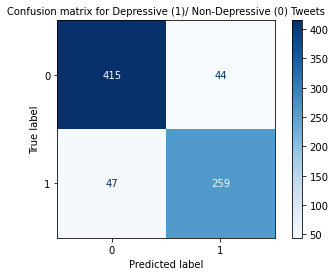



24/24 [==============================] - 0s 5ms/step


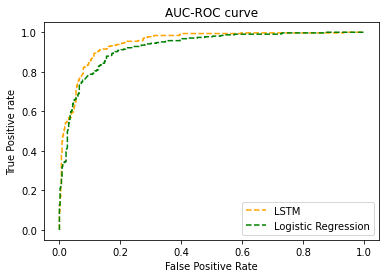

In [93]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('rnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_lstm, tpr_lstm, thresh_lstm = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_lstm, tpr_lstm, linestyle='--',color='orange', label="LSTM")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()

**Advanced model -** CNN

In [94]:
def model_builder(hp):
  hp_units = hp.Int('units', min_value=16, max_value=512, step=32)
  model = tf.keras.Sequential([encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=hp_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
  return model
  
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kttp')

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tuner.search(training_dataset, epochs=50, validation_data=val_data, validation_steps=20, callbacks = [es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kttp\tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kttp\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [95]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 464 and the optimal learning rate for the optimizer
is 0.001.



In [96]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_dataset, epochs=20, validation_data=val_data, validation_steps=20)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
194/194 [==============================] - 2s 7ms/step - loss: 0.4930 - accuracy: 0.7537 - val_loss: 0.3740 - val_accuracy: 0.8609
Epoch 2/20
194/194 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8652 - val_loss: 0.3448 - val_accuracy: 0.8656
Epoch 3/20
194/194 [==============================] - 1s 6ms/step - loss: 0.2694 - accuracy: 0.8927 - val_loss: 0.3760 - val_accuracy: 0.8516
Epoch 4/20
194/194 [==============================] - 1s 6ms/step - loss: 0.2375 - accuracy: 0.9035 - val_loss: 0.3816 - val_accuracy: 0.8469
Epoch 5/20
194/194 [==============================] - 1s 6ms/step - loss: 0.2120 - accuracy: 0.9188 - val_loss: 0.4208 - val_accuracy: 0.8547
Epoch 6/20
194/194 [==============================] - 1s 6ms/step - loss: 0.1896 - accuracy: 0.9280 - val_loss: 0.4492 - val_accuracy: 0.8453
Epoch 7/20
194/194 [==============================] - 1s 6ms/step - loss: 0.1716 - accuracy: 0.9342 - val_loss: 0.4590 - val_accuracy: 0.8578
Epoch 

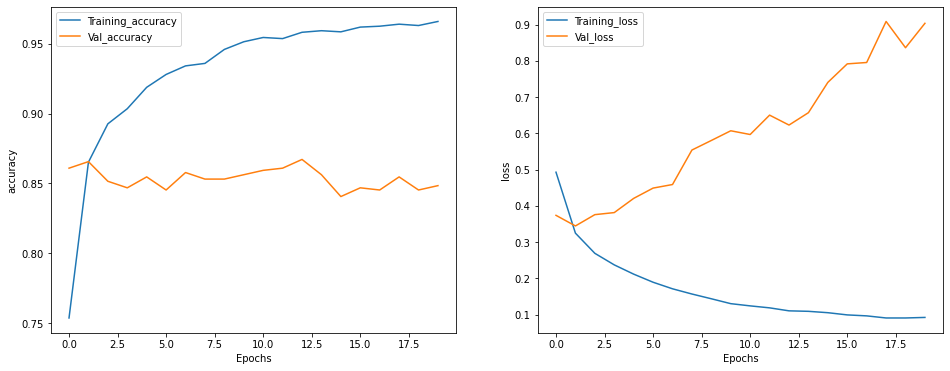

In [97]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Training_'+metric, 'Val_'+metric])
  plt.savefig('cnn_loss_curve.png')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [98]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(training_dataset, epochs=best_epoch , validation_data=val_data, validation_steps=20)

Epoch 1/13
194/194 [==============================] - 2s 7ms/step - loss: 0.4978 - accuracy: 0.7492 - val_loss: 0.3772 - val_accuracy: 0.8469
Epoch 2/13
194/194 [==============================] - 1s 6ms/step - loss: 0.3173 - accuracy: 0.8670 - val_loss: 0.3530 - val_accuracy: 0.8594
Epoch 3/13
194/194 [==============================] - 1s 6ms/step - loss: 0.2622 - accuracy: 0.8904 - val_loss: 0.3774 - val_accuracy: 0.8516
Epoch 4/13
194/194 [==============================] - 1s 6ms/step - loss: 0.2292 - accuracy: 0.9062 - val_loss: 0.4026 - val_accuracy: 0.8500
Epoch 5/13
194/194 [==============================] - 1s 6ms/step - loss: 0.2027 - accuracy: 0.9153 - val_loss: 0.4208 - val_accuracy: 0.8531
Epoch 6/13
194/194 [==============================] - 1s 6ms/step - loss: 0.1770 - accuracy: 0.9264 - val_loss: 0.4722 - val_accuracy: 0.8531
Epoch 7/13
194/194 [==============================] - 1s 6ms/step - loss: 0.1582 - accuracy: 0.9350 - val_loss: 0.4911 - val_accuracy: 0.8531
Epoch 

In [99]:
pickle.dump(hypermodel, open("model_CNN.pkl", 'wb'))

INFO:tensorflow:Assets written to: ram://3bb006ab-d3c0-44f6-8e98-cfcf6887343c/assets


INFO:tensorflow:Assets written to: ram://3bb006ab-d3c0-44f6-8e98-cfcf6887343c/assets


In [100]:
eval_result = hypermodel.evaluate(training_dataset)
print("[train loss, train accuracy]:", eval_result)

194/194 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9642
[train loss, train accuracy]: [0.08067591488361359, 0.9641704559326172]


In [101]:
eval_result = hypermodel.evaluate(testing_data)
print("[test loss, test accuracy]:", eval_result)

24/24 [==============================] - 0s 2ms/step - loss: 0.5432 - accuracy: 0.8601
[test loss, test accuracy]: [0.5431597828865051, 0.8601307272911072]


24/24 [==============================] - 0s 2ms/step

Performance on Test Set

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       459
           1       0.78      0.90      0.84       306

    accuracy                           0.86       765
   macro avg       0.85      0.87      0.86       765
weighted avg       0.87      0.86      0.86       765





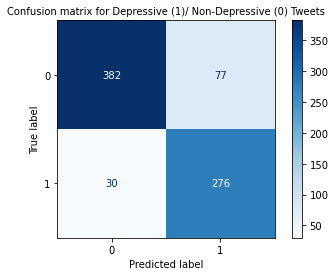



24/24 [==============================] - 0s 2ms/step


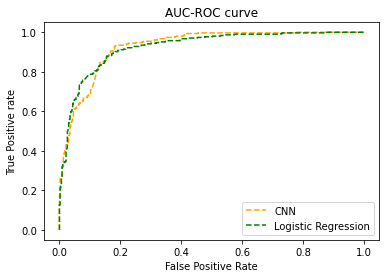

In [102]:
predictions = (hypermodel.predict(X_test['tweet']) > 0.5).astype("int32")

# Classification Report
print("\n\033[1m"+"Performance on Test Set" + "\033[0m\n")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\n")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for Depressive (1)/ Non-Depressive (0) Tweets", size = 10);
plt.savefig('cnn_confusion_m.png')
plt.show()

# AUC-ROC Curve
print("\n")
pred_y_prob = hypermodel.predict(X_test['tweet']).ravel()   
fpr_rnn, tpr_rnn, thresh_rnn = roc_curve(y_test, pred_y_prob)
plt.plot(fpr_rnn, tpr_rnn, linestyle='--',color='orange', label="CNN")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Logistic Regression")

plt.title("AUC-ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('AUC_ROC.png')
plt.show()

In [35]:
pip install pytesseract

  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0
Note: you may need to restart the kernel to use updated packages.


In [103]:
import pytesseract
from PIL import Image

# Path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Function to perform OCR on an image
def perform_ocr(image_path):
    # Open the image using PIL (Python Imaging Library)
    image = Image.open(image_path)
    
    # Perform OCR using Tesseract
    text = pytesseract.image_to_string(image)
    
    # Return the extracted text
    return text

# Example usage
image_path = 'C:/Users/archi/OneDrive/Desktop/quote.jpeg'
extracted_text = perform_ocr(image_path)

print("Extracted Text:")
print(extracted_text)

Extracted Text:
The future belongs to

those who believe in the
beauty of their dreams.

ELEANOR ROOSEVELT




In [104]:
sentence = input("Enter a sentence: ")
sentiment= detect_sentiment(sentence)

print("Sentiment: ", sentiment[0])

Enter a sentence: The future belongs to  those who believe in the beauty of their dreams.
Sentiment:  Positive
